In [1]:
import re
import pandas as pd
from datetime import timedelta
from datetime import datetime
from collections import Counter

import nltk
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentIntensityAnalyzer
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from umap import UMAP

import torch

import plotly.graph_objs as go
from emosent import get_emoji_sentiment_rank

## Getting data

In [2]:
# Specify the path to your text file
file_path = 'WhatsApp.txt'

# Initialize lists to store parsed information
dates = []
times = []
senders = []
messages = []

# Define a regular expression pattern to extract information
pattern = re.compile(r'(\d+/\d+/\d+ \d+:\d+) - ([^:]+): (.+)')

# Open the file in read mode
with open(file_path, 'r', encoding='utf-8') as file:
    # Iterate through each line in the file
    for line in file:
        # Use the regular expression to match and extract information
        match = pattern.match(line.strip())
        if match:
            # Extract date, time, sender, and message
            datetime_str, sender, message = match.groups()

            # Convert date and time to a datetime object
            datetime_obj = datetime.strptime(datetime_str, '%d/%m/%y %H:%M')

            # Append information to the respective lists
            dates.append(datetime_obj.date())
            times.append(datetime_obj.time())
            senders.append(sender)
            messages.append(message)

# Create a DataFrame for easier analysis
import pandas as pd

df = pd.DataFrame({
    'Date': dates,
    'Time': times,
    'Sender': senders,
    'Message': messages
})
# Display the DataFrame
df.head()

Date      Time             Sender               Message
0  2021-02-02  01:29:00    Schames Gonzalo  <Multimedia omitido>
1  2021-02-02  04:04:00    Schames Gonzalo  <Multimedia omitido>
2  2021-02-02  04:05:00     Ezequiel Segal          Schames 🤦‍♂️
3  2021-02-02  04:29:00  Matias Del Carril        Jajajajajajaja
4  2021-02-02  04:30:00     Ezequiel Segal  <Multimedia omitido>

In [3]:
df.columns

Index(['Date', 'Time', 'Sender', 'Message'], dtype='object')

In [4]:
df.dtypes

Date       object
Time       object
Sender     object
Message    object
dtype: object

In [5]:
df.isna().sum()

Date       0
Time       0
Sender     0
Message    0
dtype: int64

In [6]:
df.isnull().sum()

Date       0
Time       0
Sender     0
Message    0
dtype: int64

##  Cleaning date
At this moment, I clean date because I need to filter mesagges from too old. in principle I will analyse from 01/2022

In [7]:
df['Date'].value_counts()

Date
2023-08-14    524
2023-08-09    496
2021-04-16    331
2023-08-08    306
2023-08-17    297
             ... 
2021-11-28      2
2023-05-13      1
2023-09-03      1
2023-06-20      1
2022-11-13      1
Name: count, Length: 839, dtype: int64

##  Cleaning Messages
In this clean point messages that should not be passed to sensitive polariti because they make little sense or are confusing. I will clean up stop words later. At the moment it does not apply because Bert Multilanguage needs them to interpret the messages.

In [8]:
df['Message'].value_counts()

Message
<Multimedia omitido>                                                                                                                       15400
Se eliminó este mensaje.                                                                                                                     275
Jajajaj                                                                                                                                      204
Jajaja                                                                                                                                       129
Jajajaja                                                                                                                                      89
                                                                                                                                           ...  
Felicitaciones Aguja!!!! Fuerte abrazo y a seguir poblando el pais                                                        

In [9]:
#Drop rows with '<Multimedia omitido>' in the 'Message' column
df.drop(df[df['Message'] == '<Multimedia omitido>'].index, inplace=True)
# df.drop(df[df['Message'] == 'multimedia omitido'].index, inplace=True)
df.drop(df[df['Message'] == 'Se eliminó este mensaje.'].index, inplace=True)

In [10]:
df['Message'].value_counts().head(20)

Message
Jajajaj                     204
Jajaja                      129
Jajajaja                     89
🤭                            60
Si                           47
Schames                      44
Cupelli                      37
👏👏👏👏                         37
Jajajajaja                   35
Señore                       35
Schames...                   32
null                         29
👏👏👏                          29
Cupelli...                   28
jajaja                       28
🤪                            27
Eliminaste este mensaje.     26
Jaja                         26
🤦🏻‍♂️                        25
😂                            24
Name: count, dtype: int64

In [11]:
def clean_text(text):
    text = text.replace('<Media omitted>', '').replace('This message was deleted', '').replace('\n', ' ').strip()
    text = text.replace('<Multimedia omitido>', '').replace('This message was deleted', '').replace('\n', ' ').strip()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[0-9]+','', text)
    text = re.sub(r'\s+',' ', text)
    text = re.sub(r'[^\w\s]|_', '', text)
    text = re.sub(r'([a-zA-Z])\1\1','\\1', text)
    return text.lower()
df['clean_msg'] = df['Message'].apply(clean_text)

In [12]:
df['clean_msg'].value_counts().head(10)

clean_msg
              1747
jajajaj        213
jajaja         164
jajajaja       111
schames         96
cupelli         70
si              54
jajajajaja      49
jaja            37
señore          35
Name: count, dtype: int64

In [13]:
df['clean_msg'].value_counts().head(10)

clean_msg
              1747
jajajaj        213
jajaja         164
jajajaja       111
schames         96
cupelli         70
si              54
jajajajaja      49
jaja            37
señore          35
Name: count, dtype: int64

In [14]:
df[df['clean_msg']==""].head(20)

Date      Time                     Sender  \
21   2021-02-02  15:23:00              Gustavo Loras   
26   2021-02-02  16:41:00                José Soifer   
32   2021-02-02  18:24:00         Juan Diego Cupelli   
45   2021-02-02  21:51:00              Gaston Blanco   
52   2021-02-03  00:20:00         +54 9 11 5054-6026   
68   2021-02-03  17:47:00                José Soifer   
69   2021-02-03  18:23:00          Matias Del Carril   
72   2021-02-03  18:37:00         +54 9 11 5054-6026   
92   2021-02-04  00:10:00             Andrés Fuentes   
119  2021-02-04  10:14:00  Ramiro de la Cruz Quiroga   
123  2021-02-04  10:20:00                José Soifer   
139  2021-02-04  14:11:00             Ezequiel Segal   
184  2021-02-05  14:23:00                José Soifer   
187  2021-02-05  15:05:00          Santiago Bardelli   
196  2021-02-05  23:42:00             Andrés Fuentes   
200  2021-02-06  01:48:00         +54 9 11 5054-6026   
218  2021-02-06  11:56:00              Javier Melcer   
233  2021-02-06  16:49:00             Ezequiel Segal   
238  2021-02-06  16:52:00             Matias Loustau   
244  2021-02-06  19:19:00              Gustavo Loras   

                                               Message clean_msg  
21   https://www.lanacion.com.ar/politica/la-revist...            
26                             https://g.co/kgs/z9TFTm            
32                    https://vm.tiktok.com/ZMJo22T5N/            
45                                                 👏👏👏            
52                                                👏👏👏👏            
68                                                 🤣🤣🤣            
69                                                   🙂            
72                                                🤫🤫🤫🤫            
92                                                ✌️👏🏻            
119                                                👏👏👏            
123                                               🤣🤣🤣🤣            
139                                              .....            
184                                               🤣🤣🤣🤣            
187                                                  🤭            
196                                             👏🏻👏🏻👏🏻            
200                                               👏👏👏👏            
218  https://twitter.com/gogol/status/1357751034261...            
233                                                  😍            
238                       https://youtu.be/mfaZGtIazYc            
244                               😅😂🤣😅😂🤣👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻👏🏻

In [15]:
df.drop(df[df['clean_msg'] == ""].index, inplace=True)

In [16]:
df.drop(df[df['clean_msg'] == 'eliminaste este mensaje'].index, inplace=True)

In [17]:
# replace slang words with their formal equivalents
# lexicon_df = pd.read_csv('lista de stopwords.csv')
# lexicon_dict = dict(zip(lexicon_df.slang, lexicon_df.formal))
# df['clean_msg'] = df['clean_msg'].apply(lambda x: ' '.join([lexicon_dict.get(word, word) for word in x.split()]))
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(ja)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(jajajaj)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(jajajja)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(bata)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(inadi)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(loro)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(loras)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(y si)+\b', 'coincido', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(ojo)+\b', '(atencion)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(señore)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(schames)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(bardelli)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(cupelli)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(segal)+\b', '(risa)', regex=True)
# df['clean_msg'] = df['clean_msg'].str.replace(r'\b(si)+\b', 'coincido', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(epa)+\b', '(risa)', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(che)+\b', '', regex=True)
df['clean_msg'] = df['clean_msg'].str.replace(r'\b(q)+\b', '', regex=True)

In [18]:
df['clean_msg'].value_counts().head(10)

clean_msg
(risa)           972
si                54
no                33
feliz cumple      32
coincido          31
muy bueno         30
null              29
gracias           27
exacto            24
(risa) (risa)     22
Name: count, dtype: int64

In [19]:
df.isna().sum()

Date         0
Time         0
Sender       0
Message      0
clean_msg    0
dtype: int64

In [20]:
df.isnull().sum()

Date         0
Time         0
Sender       0
Message      0
clean_msg    0
dtype: int64

In [21]:
df

Date      Time               Sender  \
2      2021-02-02  04:05:00       Ezequiel Segal   
3      2021-02-02  04:29:00    Matias Del Carril   
5      2021-02-02  04:34:00    Santiago Bardelli   
6      2021-02-02  07:25:00   Juan Diego Cupelli   
7      2021-02-02  07:25:00   Juan Diego Cupelli   
...           ...       ...                  ...   
39966  2023-12-11  12:45:00       Gaston Bellera   
39967  2023-12-11  12:48:00  Gonzalo Gómez Abuin   
39968  2023-12-11  12:51:00     Marcos Silverman   
39969  2023-12-11  12:53:00     Rodolfo Gonzalez   
39970  2023-12-11  13:05:00        Gaston Blanco   

                                               Message  \
2                                         Schames 🤦‍♂️   
3                                       Jajajajajajaja   
5                                              Schames   
6                                        Finoli finoli   
7             Tiene una amonestación colectiva Schames   
...                                                ...   
39966  Buenos días amigos !! Mil gracias mi GENTE BEIA   
39967                   Feliz cumple Gasti querido!!!!   
39968   Feliz cumple Gastoncitooo !  Abrazo grandeee 🎉   
39969               Muy Feliz Cumple Gastón!! Abrazo!!   
39970            Feliz cumple tocayo!!! Un gran abrazo   

                                           clean_msg  
2                                            (risa)   
3                                             (risa)  
5                                             (risa)  
6                                      finoli finoli  
7            tiene una amonestación colectiva (risa)  
...                                              ...  
39966  buenos días amigos  mil gracias mi gente beia  
39967                     feliz cumple gasti querido  
39968        feliz cumple gastoncito  abrazo grande   
39969                 muy feliz cumple gastón abrazo  
39970             feliz cumple tocayo un gran abrazo  

[22524 rows x 5 columns]

## Feature engineering | Date

In [22]:
# Add a new column 'New_Date_Column' with the datetime values
df['rDate'] = pd.to_datetime(df['Date'])

# Extract month, year, and weekday information
df['Month'] = df['rDate'].dt.month
df['Year'] = df['rDate'].dt.year
df['Weekday'] = df['rDate'].dt.day_name()

# Display the updated DataFrame
df

Date      Time               Sender  \
2      2021-02-02  04:05:00       Ezequiel Segal   
3      2021-02-02  04:29:00    Matias Del Carril   
5      2021-02-02  04:34:00    Santiago Bardelli   
6      2021-02-02  07:25:00   Juan Diego Cupelli   
7      2021-02-02  07:25:00   Juan Diego Cupelli   
...           ...       ...                  ...   
39966  2023-12-11  12:45:00       Gaston Bellera   
39967  2023-12-11  12:48:00  Gonzalo Gómez Abuin   
39968  2023-12-11  12:51:00     Marcos Silverman   
39969  2023-12-11  12:53:00     Rodolfo Gonzalez   
39970  2023-12-11  13:05:00        Gaston Blanco   

                                               Message  \
2                                         Schames 🤦‍♂️   
3                                       Jajajajajajaja   
5                                              Schames   
6                                        Finoli finoli   
7             Tiene una amonestación colectiva Schames   
...                                                ...   
39966  Buenos días amigos !! Mil gracias mi GENTE BEIA   
39967                   Feliz cumple Gasti querido!!!!   
39968   Feliz cumple Gastoncitooo !  Abrazo grandeee 🎉   
39969               Muy Feliz Cumple Gastón!! Abrazo!!   
39970            Feliz cumple tocayo!!! Un gran abrazo   

                                           clean_msg      rDate  Month  Year  \
2                                            (risa)  2021-02-02      2  2021   
3                                             (risa) 2021-02-02      2  2021   
5                                             (risa) 2021-02-02      2  2021   
6                                      finoli finoli 2021-02-02      2  2021   
7            tiene una amonestación colectiva (risa) 2021-02-02      2  2021   
...                                              ...        ...    ...   ...   
39966  buenos días amigos  mil gracias mi gente beia 2023-12-11     12  2023   
39967                     feliz cumple gasti querido 2023-12-11     12  2023   
39968        feliz cumple gastoncito  abrazo grande  2023-12-11     12  2023   
39969                 muy feliz cumple gastón abrazo 2023-12-11     12  2023   
39970             feliz cumple tocayo un gran abrazo 2023-12-11     12  2023   

       Weekday  
2      Tuesday  
3      Tuesday  
5      Tuesday  
6      Tuesday  
7      Tuesday  
...        ...  
39966   Monday  
39967   Monday  
39968   Monday  
39969   Monday  
39970   Monday  

[22524 rows x 9 columns]

## Feature engineering | sentiment analysis

In [23]:
df.drop(df[df['clean_msg'] == "null"].index, inplace=True)

In [24]:
df.drop(df[df['clean_msg'] == " "].index, inplace=True)

In [25]:
df['clean_msg'].value_counts().head(20)

clean_msg
(risa)               972
si                    54
no                    33
feliz cumple          32
coincido              31
muy bueno             30
gracias               27
exacto                24
(risa) (risa)         22
totalmente            18
brillante             18
ok                    14
correcto              14
feliz cumpleee        14
si si                 14
olvidate              14
gracias muchachos     11
melcer                11
hermoso               11
muchas gracias        11
Name: count, dtype: int64

In [26]:
import emoji

In [27]:
df['emoji'] = df['Message'].apply(lambda x: ''.join(c for c in x if c in emoji.EMOJI_DATA))

In [28]:
df['emoji'].value_counts()

emoji
                  20597
🤷🏻♂                 196
🤦🏻♂                  76
🤷🏻♂🤦🏻♂               49
🤔                    44
                  ...  
🤦🏻♂😡🤬                 1
🥲                     1
👏🏻👏🏻👏🏻👏🏻👏🏻👍🏻          1
😂😂😂🙈🙏                 1
💪💪💪🎈🎈🎀🎀🎀🎁🎁🎁🎁🎁🎁        1
Name: count, Length: 764, dtype: int64

### Sentiment polarity
It processes the messages in such a way that it gets the polarity of the feeling, not yet clean the stop words because they are used for the Bert to interpret the sentences.

In [29]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [30]:
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

In [31]:
# tokens = tokenizer.encode('excellent', return_tensors='pt')
# result = model(tokens)
# result.logits
# int(torch.argmax(result.logits))+1

In [32]:
def get_sentiment_token(text):
    tokens = tokenizer.encode(text, return_tensors='pt')
    blob = model(tokens)
    return int(torch.argmax(blob.logits)) + 1

In [33]:
df

Date      Time               Sender  \
2      2021-02-02  04:05:00       Ezequiel Segal   
3      2021-02-02  04:29:00    Matias Del Carril   
5      2021-02-02  04:34:00    Santiago Bardelli   
6      2021-02-02  07:25:00   Juan Diego Cupelli   
7      2021-02-02  07:25:00   Juan Diego Cupelli   
...           ...       ...                  ...   
39966  2023-12-11  12:45:00       Gaston Bellera   
39967  2023-12-11  12:48:00  Gonzalo Gómez Abuin   
39968  2023-12-11  12:51:00     Marcos Silverman   
39969  2023-12-11  12:53:00     Rodolfo Gonzalez   
39970  2023-12-11  13:05:00        Gaston Blanco   

                                               Message  \
2                                         Schames 🤦‍♂️   
3                                       Jajajajajajaja   
5                                              Schames   
6                                        Finoli finoli   
7             Tiene una amonestación colectiva Schames   
...                                                ...   
39966  Buenos días amigos !! Mil gracias mi GENTE BEIA   
39967                   Feliz cumple Gasti querido!!!!   
39968   Feliz cumple Gastoncitooo !  Abrazo grandeee 🎉   
39969               Muy Feliz Cumple Gastón!! Abrazo!!   
39970            Feliz cumple tocayo!!! Un gran abrazo   

                                           clean_msg      rDate  Month  Year  \
2                                            (risa)  2021-02-02      2  2021   
3                                             (risa) 2021-02-02      2  2021   
5                                             (risa) 2021-02-02      2  2021   
6                                      finoli finoli 2021-02-02      2  2021   
7            tiene una amonestación colectiva (risa) 2021-02-02      2  2021   
...                                              ...        ...    ...   ...   
39966  buenos días amigos  mil gracias mi gente beia 2023-12-11     12  2023   
39967                     feliz cumple gasti querido 2023-12-11     12  2023   
39968        feliz cumple gastoncito  abrazo grande  2023-12-11     12  2023   
39969                 muy feliz cumple gastón abrazo 2023-12-11     12  2023   
39970             feliz cumple tocayo un gran abrazo 2023-12-11     12  2023   

       Weekday emoji  
2      Tuesday    🤦♂  
3      Tuesday        
5      Tuesday        
6      Tuesday        
7      Tuesday        
...        ...   ...  
39966   Monday        
39967   Monday        
39968   Monday     🎉  
39969   Monday        
39970   Monday        

[22478 rows x 10 columns]

In [34]:
data = df[df['Year'] > 2022]
data.shape

(9849, 10)

In [35]:
import torch.nn.functional as F

def get_sentiment_token(text):
    # Tokenize the text
    tokens = tokenizer.encode(text, return_tensors='pt', truncation=True)
    
    # Check if the tokens exceed the maximum sequence length
    if tokens.size(1) > 512:
        print(f"Tokens size exceeds maximum sequence length: {tokens.size(1)}")
        # Pad the tensor if needed
        tokens = F.pad(tokens, (0, 512 - tokens.size(1)))
    
    # Forward pass through the model
    blob = model(tokens)
    
    # Return the sentiment polarity
    return int(torch.argmax(blob.logits)) + 1

In [36]:
get_sentiment_token('risa')

5

In [37]:
# # Apply sentiment analysis to the 'Message' column
# data['Sentiment_Polarity'] = data['clean_msg'].apply(get_sentiment_token)
# data['Sentiment_Label'] = data['Sentiment_Polarity'].apply(lambda x: 'Positive' if x == 5 else 'Negative' if x == 1 else 'Neutral')
# data.to_csv('data_labeled.csv', index=False)

In [38]:
data_labeled = pd.read_csv('data_labeled.csv')
data_labeled.head()

Date      Time                     Sender  \
0  2023-01-01  00:03:00                José Soifer   
1  2023-01-01  00:04:00  Ramiro de la Cruz Quiroga   
2  2023-01-01  00:04:00                José Soifer   
3  2023-01-01  00:04:00                José Soifer   
4  2023-01-01  00:05:00          Santiago Bardelli   

                                Message                        clean_msg  \
0           Feliz año Europa 🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾                feliz año europa    
1                 Feliz Año gente!!! ❣️                 feliz año gente    
2  El resto del mundo que esperen 🥱🥱🤣🤣🤣  el resto del mundo que esperen    
3               Feliz año Ramiro carajo          feliz año ramiro carajo   
4                Feliz 2023 para todos¡                 feliz para todos   

        rDate  Month  Year Weekday       emoji  Sentiment_Polarity  \
0  2023-01-01      1  2023  Sunday  🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾                   5   
1  2023-01-01      1  2023  Sunday           ❣                   5   
2  2023-01-01      1  2023  Sunday       🥱🥱🤣🤣🤣                   5   
3  2023-01-01      1  2023  Sunday         NaN                   5   
4  2023-01-01      1  2023  Sunday         NaN                   5   

  Sentiment_Label  
0        Positive  
1        Positive  
2        Positive  
3        Positive  
4        Positive

In [39]:
data_labeled['Sentiment_Label'].value_counts()

Sentiment_Label
Negative    3441
Neutral     3373
Positive    3035
Name: count, dtype: int64

In [40]:
data_filtered=data_labeled

### Remove Stop-words 
At this point I make sure, the words have the correct sensitive polarity and I clean the stop words so that the most used words can be seen.

In [41]:
stopwords_list = pd.read_csv('lista de stopwords.csv', encoding='ISO-8859-1')

In [42]:
# # remove stop words
stopwords_list = pd.read_csv('lista de stopwords.csv', encoding='ISO-8859-1')['words'].tolist()
data_filtered['clean_msg'] = data_filtered['clean_msg'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stopwords_list]))

In [43]:
from PIL import Image

In [44]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))
    #).generate(data)

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

### Remove remaining Stop-words manually
Some words not included in the stop-words file are still in the list of positive words. I remove them to leave only nouns, adjectives and other words that really represent the positive meaning of the messages.

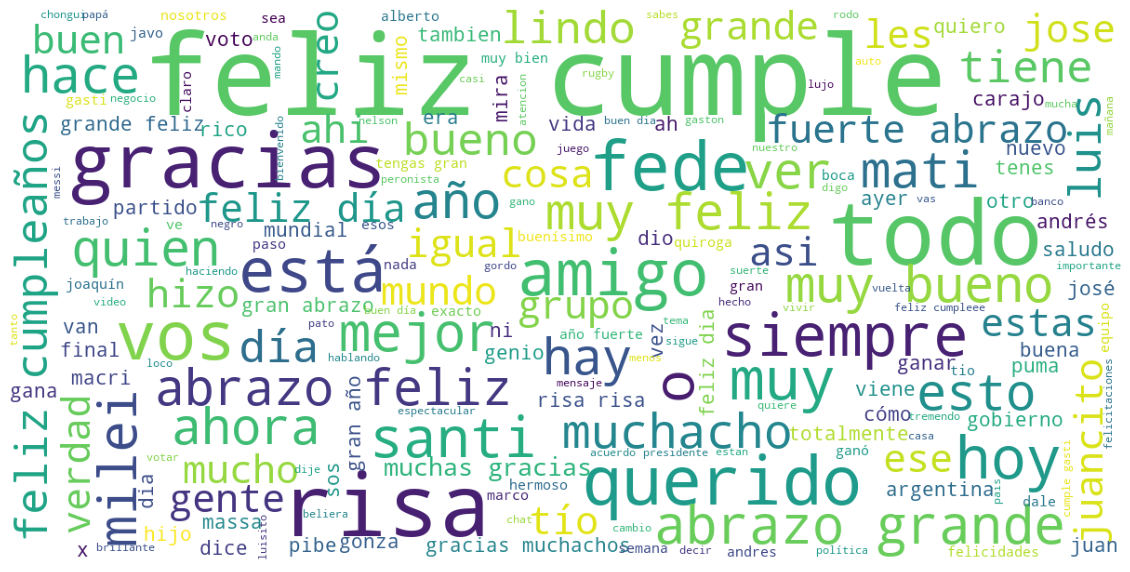

In [45]:
Positive = data_filtered[data_filtered["Sentiment_Label"] == 'Positive']
concatenated_message = ''
for i in range(Positive.shape[0]):
    concatenated_message += ' ' + Positive['clean_msg'].iloc[i]

# If you want to remove leading space
concatenated_message = concatenated_message.strip()
show_wordcloud(concatenated_message)

In [46]:
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(o)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(ayer)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(mucha)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(muchas)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(mucho)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(ahi)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(esos)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(otro)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(hoy)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(nada)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(nada)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(está)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(estás)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(ahora)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(esto)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(tanto)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(cumpleee)+\b', 'cumple', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(cómo)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(ver)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(x)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(dice)+\b', '', regex=True)
data_filtered['clean_msg'] = data_filtered['clean_msg'].str.replace(r'\b(creo)+\b', '', regex=True)

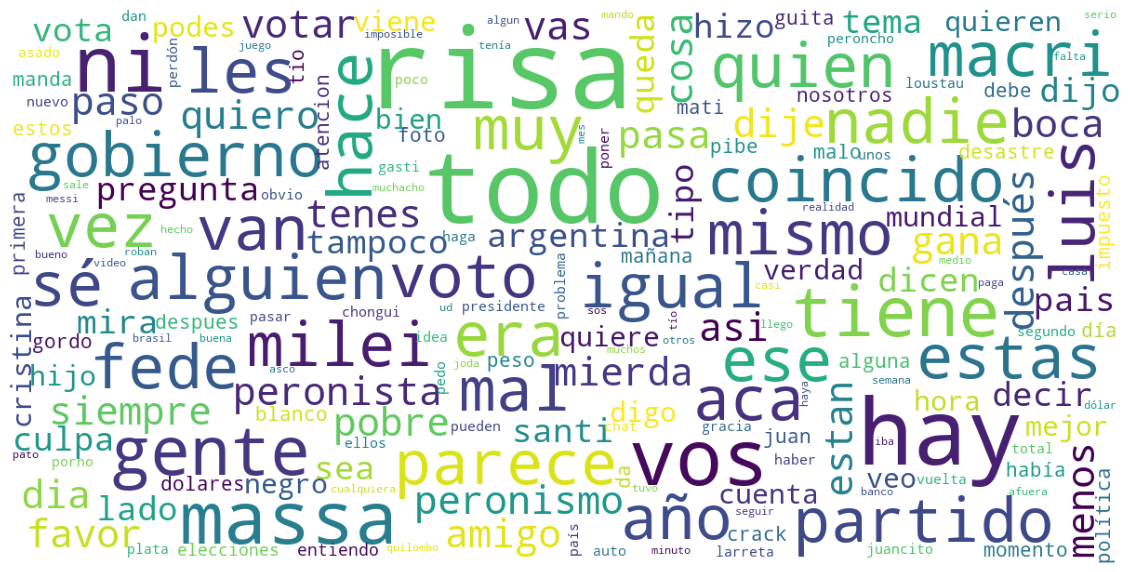

In [47]:
Negative = data_filtered[data_filtered["Sentiment_Label"] == 'Negative']
Negative_concatenated = ''
for i in range(Negative.shape[0]):
    Negative_concatenated += ' ' + Negative['clean_msg'].iloc[i]

# If you want to remove leading space
Negative_concatenated = Negative_concatenated.strip()
show_wordcloud(Negative_concatenated)

##  Feature engineering | Time | Daytime

In [48]:
data_filtered.columns

Index(['Date', 'Time', 'Sender', 'Message', 'clean_msg', 'rDate', 'Month',
       'Year', 'Weekday', 'emoji', 'Sentiment_Polarity', 'Sentiment_Label'],
      dtype='object')

In [49]:
data_filtered['Time'] = pd.to_datetime(data_filtered['Time'], format='%H:%M:%S').dt.time
# Create a new column 'time_f' with formatted time values
data_filtered['Time_day'] = data_filtered['Time'].apply(lambda x: x.strftime('%H:%M:%S'))

In [50]:
data_filtered['Time'] = pd.to_datetime(data_filtered['Time'], format='%H:%M:%S').dt.time
# Create a new column 'time_f' with formatted time values
data_filtered['time_f'] = data_filtered['Time'].apply(lambda x: x.strftime('%H:%M:%S'))

# Create new columns for morning, afternoon, and night
data_filtered['Morning'] = ((data_filtered['Time'].apply(lambda x: x.hour) >= 6) & (data_filtered['Time'].apply(lambda x: x.hour) < 13)).astype(int)
data_filtered['Afternoon'] = ((data_filtered['Time'].apply(lambda x: x.hour) >= 13) & (data_filtered['Time'].apply(lambda x: x.hour) < 20)).astype(int)
data_filtered['Night'] = ((data_filtered['Time'].apply(lambda x: x.hour) >= 20) | (data_filtered['Time'].apply(lambda x: x.hour) < 6)).astype(int)

# Combine morning, afternoon, and night into a single column 'Time-Day'
def classify_time(row):
    if row['Morning'] == 1:
        return 'Morning'
    elif row['Afternoon'] == 1:
        return 'Afternoon'
    elif row['Night'] == 1:
        return 'Night'
    else:
        return None

data_filtered['Time-Day'] = data_filtered.apply(classify_time, axis=1)
# Display the updated DataFrame
data_filtered.dtypes

Date                  object
Time                  object
Sender                object
Message               object
clean_msg             object
rDate                 object
Month                  int64
Year                   int64
Weekday               object
emoji                 object
Sentiment_Polarity     int64
Sentiment_Label       object
Time_day              object
time_f                object
Morning                int32
Afternoon              int32
Night                  int32
Time-Day              object
dtype: object

In [51]:
# !pip install openpyxl --upgrade

##  Feature engineering | Sender | nickname

In [52]:
# nickname = pd.read_excel('sender.xlsx')
# nickname.dtypes

In [53]:
data_filtered['Sender'].value_counts()

Sender
Luis Recagno                 1748
Federico Scheerle            1656
Juan Diego Cupelli           1300
Santiago Bardelli             816
Gustavo Loras                 605
Gaston Bellera                541
Matias Del Carril             455
Matias Loustau                390
Schames Gonzalo               372
Ezequiel Segal                334
Carlos Ure                    331
Nelson Ostroyeski             317
José Soifer                   217
Gonzalo Gómez Abuin           142
Andrés Fuentes                138
Javier Melcer                 131
Martin Espinosa               118
Ramiro de la Cruz Quiroga      97
Gaston Blanco                  70
Marcos Silverman               34
Rodolfo Gonzalez               20
Joaquin Rapela                 17
Name: count, dtype: int64

In [54]:
# Sample DataFrame with a column named 'Sender'
# data_filtered = {'Sender': ['Juan Diego Cupelli', 'Gustavo Loras', 'Santiago Bardelli', 'Federico Scheerle',
#                  'Gaston Bellera','Luis Recagno','Schames Gonzalo',
#                  'José Soifer','Ezequiel Segal','Matias Loustau','Matias Del Carril'
#                  ,'Andrés Fuentes','Carlos Ure','Nelson Ostroyeski', 'Javier Melcer',
#                  'Gonzalo Gómez Abuin','Martin Espinosa','Ramiro de la Cruz Quiroga',
#                  'Gaston Blanco','Marcos Silverman','Rodolfo Gonzalez','Miguel García',
#                  'Joaquin Rapela','Gentile Alejandro Christian','Albornoz Javier'
#                 ]}

# data_filtered = pd.DataFrame(data_filtered)

# Define a dictionary mapping full names to nicknames
nickname_mapping = {
    'Juan Diego Cupelli': 'Juan',
    'Gustavo Loras': 'Gusta',
    'Santiago Bardelli': 'Barde',
    'Federico Scheerle': 'Fede',
    'Gaston Bellera': 'Colo',
    'Luis Recagno':'Chongui',
    'Schames Gonzalo':'Schames',
    'José Soifer':'Jose',
    'Ezequiel Segal':'Eze',
    'Matias Loustau':'Matias',
    'Matias Del Carril':'Delca',
    'Andrés Fuentes':'Chogau',
    'Carlos Ure':'Charlie',
    'Nelson Ostroyeski':'Nelson',
    'Javier Melcer':'Javo',
    'Gonzalo Gómez Abuin':'Aguja',
    'Martin Espinosa':'Morza',
    'Ramiro de la Cruz Quiroga':'Quiroga',
    'Gaston Blanco':'Blanco',
    'Marcos Silverman':'Marcos',
    'Rodolfo Gonzalez':'Rodo',
    'Miguel García':'Garcia',
    'Joaquin Rapela':'Rape',
    'Gentile Alejandro Christian':'Genti',
    'Albornoz Javier':'Albor'
}

# Add a new column 'Nickname' with corresponding nicknames
data_filtered['Nickname'] = data_filtered['Sender'].map(nickname_mapping)
data_filtered.head()

Date      Time                     Sender  \
0  2023-01-01  00:03:00                José Soifer   
1  2023-01-01  00:04:00  Ramiro de la Cruz Quiroga   
2  2023-01-01  00:04:00                José Soifer   
3  2023-01-01  00:04:00                José Soifer   
4  2023-01-01  00:05:00          Santiago Bardelli   

                                Message                clean_msg       rDate  \
0           Feliz año Europa 🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾         feliz año europa  2023-01-01   
1                 Feliz Año gente!!! ❣️          feliz año gente  2023-01-01   
2  El resto del mundo que esperen 🥱🥱🤣🤣🤣      resto mundo esperen  2023-01-01   
3               Feliz año Ramiro carajo  feliz año ramiro carajo  2023-01-01   
4                Feliz 2023 para todos¡              feliz todos  2023-01-01   

   Month  Year Weekday       emoji  Sentiment_Polarity Sentiment_Label  \
0      1  2023  Sunday  🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾                   5        Positive   
1      1  2023  Sunday           ❣                   5        Positive   
2      1  2023  Sunday       🥱🥱🤣🤣🤣                   5        Positive   
3      1  2023  Sunday         NaN                   5        Positive   
4      1  2023  Sunday         NaN                   5        Positive   

   Time_day    time_f  Morning  Afternoon  Night Time-Day Nickname  
0  00:03:00  00:03:00        0          0      1    Night     Jose  
1  00:04:00  00:04:00        0          0      1    Night  Quiroga  
2  00:04:00  00:04:00        0          0      1    Night     Jose  
3  00:04:00  00:04:00        0          0      1    Night     Jose  
4  00:05:00  00:05:00        0          0      1    Night    Barde

In [55]:
data_filtered.dtypes

Date                  object
Time                  object
Sender                object
Message               object
clean_msg             object
rDate                 object
Month                  int64
Year                   int64
Weekday               object
emoji                 object
Sentiment_Polarity     int64
Sentiment_Label       object
Time_day              object
time_f                object
Morning                int32
Afternoon              int32
Night                  int32
Time-Day              object
Nickname              object
dtype: object

# Exploratory data analysis

In [56]:
selected_columns = ['Date','Nickname','Message', 'clean_msg','emoji','time_f','Sentiment_Label','Time-Day','Weekday','Month','Year']
chat = data_filtered[selected_columns]

In [57]:
# Assuming 'Time' is the current name of the column and data_filtered is your DataFrame
chat = chat.rename(columns={'rDate': 'date'})
chat = chat.rename(columns={'time_f': 'hour'})
chat = chat.rename(columns={'Sentiment_Label': 'sentiment'})
chat = chat.rename(columns={'Nickname': 'username'})
chat = chat.rename(columns={'Message': 'message'})

In [58]:
chat.head()

Date username                               message  \
0  2023-01-01     Jose           Feliz año Europa 🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾   
1  2023-01-01  Quiroga                 Feliz Año gente!!! ❣️   
2  2023-01-01     Jose  El resto del mundo que esperen 🥱🥱🤣🤣🤣   
3  2023-01-01     Jose               Feliz año Ramiro carajo   
4  2023-01-01    Barde                Feliz 2023 para todos¡   

                 clean_msg       emoji      hour sentiment Time-Day Weekday  \
0         feliz año europa  🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾  00:03:00  Positive    Night  Sunday   
1          feliz año gente           ❣  00:04:00  Positive    Night  Sunday   
2      resto mundo esperen       🥱🥱🤣🤣🤣  00:04:00  Positive    Night  Sunday   
3  feliz año ramiro carajo         NaN  00:04:00  Positive    Night  Sunday   
4              feliz todos         NaN  00:05:00  Positive    Night  Sunday   

   Month  Year  
0      1  2023  
1      1  2023  
2      1  2023  
3      1  2023  
4      1  2023

In [59]:
chat.shape

(9849, 11)

## Conversation stats

## Use of emojis
The results showed that 😂 Face with Tears of Joy was the most commonly used emoji, followed by 👍 Thumbs Up, 🙏 Folded Hands, and 🥰 Smiling Face with Hearts. According to Emojipedia, these emojis suggest positive emotions, which could be assumed that the chat messages with emojis tended to be more positive in tone.

Next, I analyzed the word count of the messages sent by each member to understand their communication styles.

In [60]:
chat.groupby('username').agg({'message': 'count',
                              'emoji': lambda x: ' '.join(set(emoji for emojis in x.dropna() for emoji in emojis))
                              }).sort_values(by='message', ascending=False)

message                                              emoji
username                                                            
Chongui      1748                                        🏼 ☝ 👇 🤑 😁 🤪
Fede         1656        😘 😜 ☝ ☎ 📸 🐔 💙 😝 👏 🤬 🤦 ❤ 🤪 🙄 💖 😂 🥳 ♂ 😁 🤔 😭 💛
Juan         1300                                              🤔 ⚠ 🐶
Barde         816                                            🦍 🥳 🎂 🚨
Gusta         605  ⚕ 🫂 🐔 👆 🏻 👁 🎣 🍾 👏 🍑 😳 😖 🤦 😉 🫣 👌 🫢 🙌 😔 🏿 😱 👉 ⚖ ...
Colo          541              👨 ☕ 💼 🎂 🎤 🎊 🦜 🚢 🌞 🦆 🎁 🤣 👎 👌 💩 🥇 🎉 😭 💤
Delca         455                                                  🙁
Matias        390                                                   
Schames       372                                                👆 💨
Eze           334                                😂 🙄 🌱 👏 😎 ♂ 🏉 🙏 🤦 🤪
Charlie       331                                                  🍾
Nelson        317                                                  😂
Jose          217  📸 💪 ☃ 😄 🎊 💸 🥖 🚢 🍷 🍾 🍖 🎈 💃 🎁 🤣 🥱 🏈 🎾 🔥 🌪 😂 🙈 😴 ...
Aguja         142                                          😊 🙏 🥹 🏻 ❤
Chogau        138                                              😜 🦜 🤪
Javo          131                                      😂 🥳 ♂ 💪 🤦 👍 😀
Morza         118                                                   
Quiroga        97            😅 😜 ☝ 🫂 😀 😄 🤗 😉 😌 🤣 🤪 🎉 🤩 ❣ 😁 🤔 🥹 😍 😭 ☺
Blanco         70                                              🤣 🙏 😛
Marcos         34                                🥂 🍷 🎉 🍾 👏 ♂ 🏻 🤦 👍 👌
Rodo           20                                                   
Rape           17                                                  🙂

In [61]:
chat['emoji']

0       🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾
1                ❣
2            🥱🥱🤣🤣🤣
3              NaN
4              NaN
           ...    
9844           NaN
9845           NaN
9846             🎉
9847           NaN
9848           NaN
Name: emoji, Length: 9849, dtype: object

In [62]:
# Assuming 'emoji' is the name of the column and data_filtered is your DataFrame
chat['is_emoji_empty'] = chat['emoji'].apply(lambda x: 1 if pd.isna(x) or x == '' else 0)

In [63]:
grouped_chat = chat.groupby('is_emoji_empty').size().reset_index(name='count')
grouped_chat

is_emoji_empty  count
0               0    582
1               1   9267

In [64]:
import plotly.graph_objects as go

# Assuming chat is your DataFrame
chat['is_emoji'] = chat['emoji'].apply(lambda x: True if x != '' else False)
grouped_chat = chat.groupby('is_emoji_empty').size().reset_index(name='count')

# Create a pie chart using Plotly
fig = go.Figure(data=go.Pie(
    labels=['Chats without emoji', 'Chats with emoji'],
    values=grouped_chat['count'],
    hole=0.4,
    marker=dict(colors=['#25D366', '#075E54'])
))

fig.update_traces(hoverinfo='label+value')
fig.update_layout(title='Distribution of Emoji Empty Status')
fig.show()

In [65]:
# rank of emojis
from collections import Counter
emoji_counter = Counter()
for message in chat['emoji']:
    if not pd.isna(message) and isinstance(message, str):
        emoji_counter.update(message)
emoji_df = pd.DataFrame(emoji_counter.most_common(), columns=['emoji', 'count'], index=range(1, len(emoji_counter)+1))
emoji_df.head()

emoji  count
1     😂    213
2     🏻    207
3     🤣    185
4     😅    157
5     ♂    118

## Messages per member
Next, I analyzed the word count of the messages sent by each member to understand their communication styles.

In [66]:
from whatstk import WhatsAppChat, FigureBuilder

In [67]:
fig = FigureBuilder(chat.assign(message=chat['message'].apply(lambda x: ''.join([' ' for i in range(len(x.split())) if x != '<Media omitted>'])))
                    ).user_msg_length_boxplot(title=None, xlabel=None)

In [68]:
fig

## Most common words
Finally, I created a word cloud to see which words were most commonly used in the group chat.

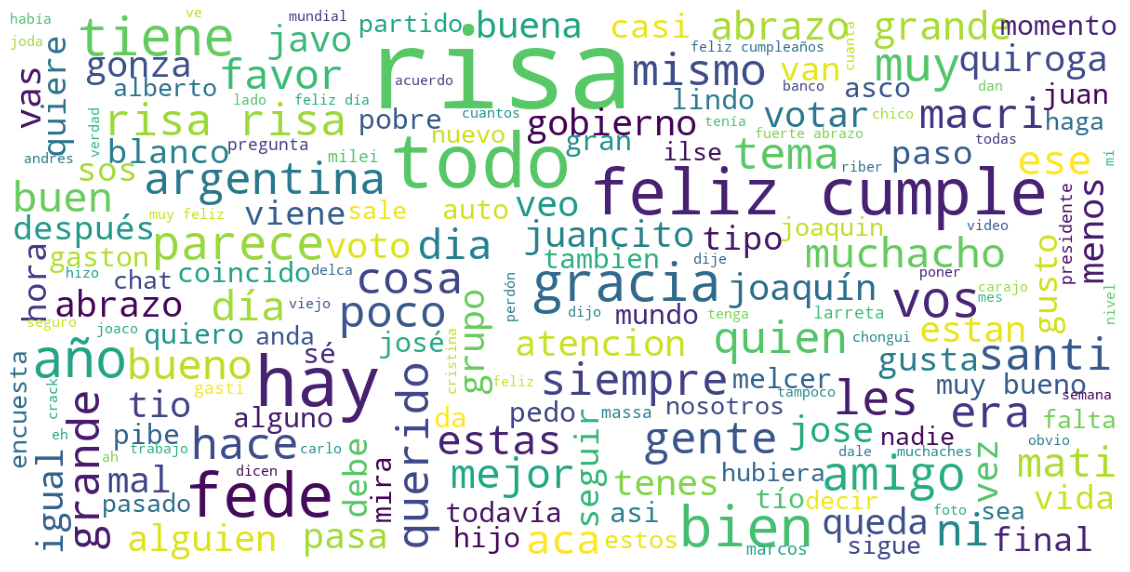

In [69]:
concatenated_message = ''
for i in range(Positive.shape[0]):
    concatenated_message += ' ' + chat['clean_msg'].iloc[i]
concatenated_message = concatenated_message.strip()
show_wordcloud(concatenated_message)

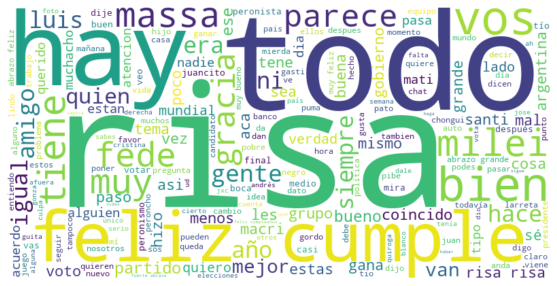

In [70]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming 'clean_msg' is the column containing text data
text_data = ' '.join(chat['clean_msg'])

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Display the generated word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Message activity
Looking at the conversation stats, it was pretty obvious that some members were more active than others. But, to really get what was going on in this group chat, I needed to see how often messages were being sent over time. Thus, I delved deeper to get the scoop on message activity.

## Activity by day

In [71]:
chat['date'] = pd.to_datetime(chat['Date'])
chat.head()

Date username                               message  \
0  2023-01-01     Jose           Feliz año Europa 🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾   
1  2023-01-01  Quiroga                 Feliz Año gente!!! ❣️   
2  2023-01-01     Jose  El resto del mundo que esperen 🥱🥱🤣🤣🤣   
3  2023-01-01     Jose               Feliz año Ramiro carajo   
4  2023-01-01    Barde                Feliz 2023 para todos¡   

                 clean_msg       emoji      hour sentiment Time-Day Weekday  \
0         feliz año europa  🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾  00:03:00  Positive    Night  Sunday   
1          feliz año gente           ❣  00:04:00  Positive    Night  Sunday   
2      resto mundo esperen       🥱🥱🤣🤣🤣  00:04:00  Positive    Night  Sunday   
3  feliz año ramiro carajo         NaN  00:04:00  Positive    Night  Sunday   
4              feliz todos         NaN  00:05:00  Positive    Night  Sunday   

   Month  Year  is_emoji_empty  is_emoji       date  
0      1  2023               0      True 2023-01-01  
1      1  2023               0      True 2023-01-01  
2      1  2023               0      True 2023-01-01  
3      1  2023               1      True 2023-01-01  
4      1  2023               1      True 2023-01-01

In [72]:
fig = FigureBuilder(chat).user_interventions_count_linechart(title=None, xlabel=None, all_users=True)
fig

## Hot days of politic

In [73]:
chat.columns

Index(['Date', 'username', 'message', 'clean_msg', 'emoji', 'hour',
       'sentiment', 'Time-Day', 'Weekday', 'Month', 'Year', 'is_emoji_empty',
       'is_emoji', 'date'],
      dtype='object')

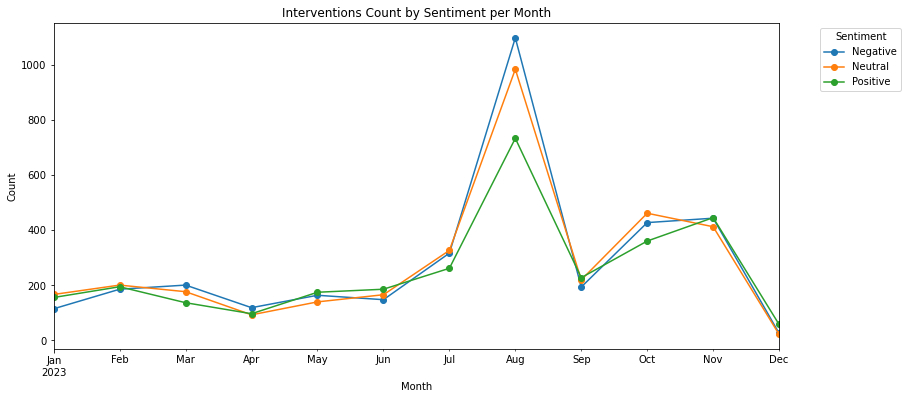

In [74]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'date' and 'sentiment' are the relevant columns in your DataFrame (chat)
# Replace them with the actual column names in your DataFrame
chat['date'] = pd.to_datetime(chat['date'])  # Convert 'date' column to datetime if not already
chat['month'] = chat['date'].dt.to_period('M')  # Extract month

# Group by both 'month' and 'sentiment', count interventions, and unstack the result
grouped_data = chat.groupby(['month', 'sentiment']).size().unstack(fill_value=0)

# Plotting the line chart
fig, ax = plt.subplots(figsize=(13, 6))
grouped_data.plot(kind='line', ax=ax, marker='o')

# Customize the plot
ax.set_title("Interventions Count by Sentiment per Month")
ax.set_xlabel("Month")
ax.set_ylabel("Count")
plt.legend(title='Sentiment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [75]:
chat.columns

Index(['Date', 'username', 'message', 'clean_msg', 'emoji', 'hour',
       'sentiment', 'Time-Day', 'Weekday', 'Month', 'Year', 'is_emoji_empty',
       'is_emoji', 'date', 'month'],
      dtype='object')

In [76]:
chat.head()

Date username                               message  \
0  2023-01-01     Jose           Feliz año Europa 🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾   
1  2023-01-01  Quiroga                 Feliz Año gente!!! ❣️   
2  2023-01-01     Jose  El resto del mundo que esperen 🥱🥱🤣🤣🤣   
3  2023-01-01     Jose               Feliz año Ramiro carajo   
4  2023-01-01    Barde                Feliz 2023 para todos¡   

                 clean_msg       emoji      hour sentiment Time-Day Weekday  \
0         feliz año europa  🍾🍾🍾🍾🍾🍾🍾🍾🍾🍾  00:03:00  Positive    Night  Sunday   
1          feliz año gente           ❣  00:04:00  Positive    Night  Sunday   
2      resto mundo esperen       🥱🥱🤣🤣🤣  00:04:00  Positive    Night  Sunday   
3  feliz año ramiro carajo         NaN  00:04:00  Positive    Night  Sunday   
4              feliz todos         NaN  00:05:00  Positive    Night  Sunday   

   Month  Year  is_emoji_empty  is_emoji       date    month  
0      1  2023               0      True 2023-01-01  2023-01  
1      1  2023               0      True 2023-01-01  2023-01  
2      1  2023               0      True 2023-01-01  2023-01  
3      1  2023               1      True 2023-01-01  2023-01  
4      1  2023               1      True 2023-01-01  2023-01

In [77]:
Hot_days = chat.groupby('Month').count()[['message']].reset_index()
Hot_days = Hot_days.sort_values(by='message')
Hot_days = Hot_days.sort_values(by='message', ascending=False)
Hot_days.head()

Month  message
7       8     2818
10     11     1303
9      10     1251
6       7      906
8       9      642

In [78]:
Hot_dayx = chat[(chat['Month'] >= 8) & (chat['sentiment'] == 'Negative')]
Hot_dayx.head(3)

Date username                                            message  \
3730  2023-08-01    Barde  Le cancelaron 18 presentaciones por decir bolu...   
3732  2023-08-01     Juan                            ...no te pongas cau....   
3733  2023-08-01     Juan                       ....viene carai octubre.....   

                                      clean_msg emoji      hour sentiment  \
3730  cancelaron presentaciones decir boludeces   NaN  08:17:00  Negative   
3732                              no pongas cau   NaN  14:37:00  Negative   
3733                        viene carai octubre   NaN  14:38:00  Negative   

       Time-Day  Weekday  Month  Year  is_emoji_empty  is_emoji       date  \
3730    Morning  Tuesday      8  2023               1      True 2023-08-01   
3732  Afternoon  Tuesday      8  2023               1      True 2023-08-01   
3733  Afternoon  Tuesday      8  2023               1      True 2023-08-01   

        month  
3730  2023-08  
3732  2023-08  
3733  2023-08

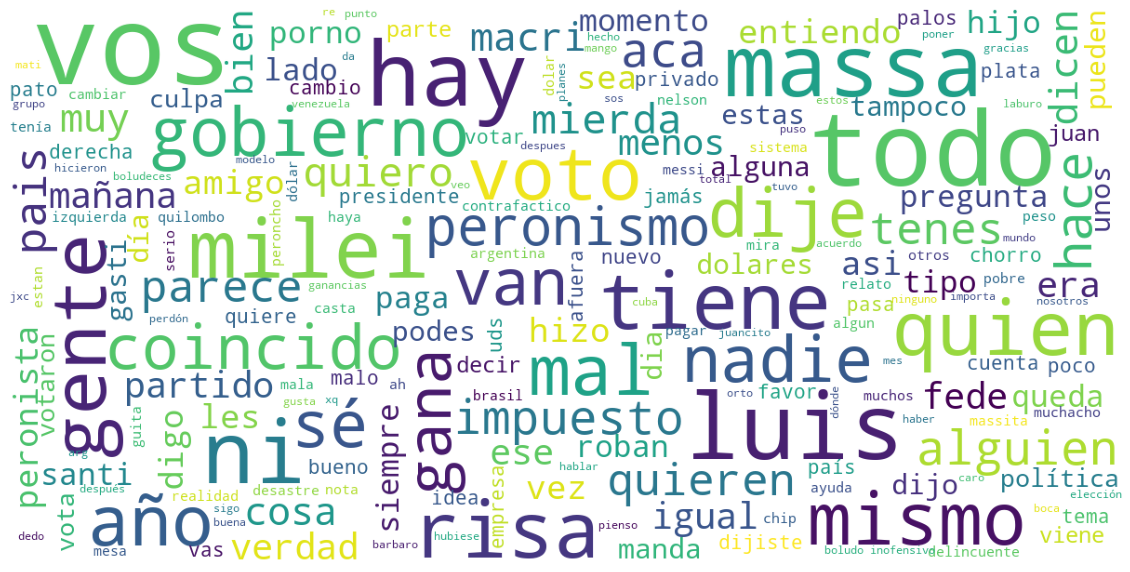

In [79]:
Negative_Month = chat[(chat['Month'] == 8) & (chat['sentiment'] == 'Negative')]
Negative_Month_concatenated = ''
for i in range(Negative_Month.shape[0]):
    Negative_Month_concatenated += ' ' + Negative_Month['clean_msg'].iloc[i]
Negative_Month_concatenated = Negative_Month_concatenated.strip()
show_wordcloud(Negative_Month_concatenated)

In [80]:
August = chat[chat['Month'] == 8]
fig = go.Figure(data=go.Pie(labels=['Negative', 'Neutral', 'Positive'],
                            values=August.groupby('sentiment').count()[['message']].reset_index()['message'],
                            hole=.4, marker=dict(colors=['#075E54','#dcf8c6', '#25D366', ])))
fig.update_traces(hoverinfo='label+value')

In [81]:
fig = FigureBuilder(chat).user_interventions_count_linechart(cumulative=True, title=None, xlabel=None)
fig

In [82]:
fig = FigureBuilder(chat).user_interventions_count_linechart(date_mode='date', title=None, xlabel=None)
fig

## Activity by hour 

In [83]:
chat.columns

Index(['Date', 'username', 'message', 'clean_msg', 'emoji', 'hour',
       'sentiment', 'Time-Day', 'Weekday', 'Month', 'Year', 'is_emoji_empty',
       'is_emoji', 'date', 'month'],
      dtype='object')

In [84]:
chat.dtypes

Date                      object
username                  object
message                   object
clean_msg                 object
emoji                     object
hour                      object
sentiment                 object
Time-Day                  object
Weekday                   object
Month                      int64
Year                       int64
is_emoji_empty             int64
is_emoji                    bool
date              datetime64[ns]
month                  period[M]
dtype: object

In [85]:
chat['hour'] = pd.to_datetime(chat['hour']).dt.hour

C:\Users\Santiago\AppData\Local\Temp\ipykernel_2636\3138549884.py:1: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [86]:
# chat['hour'] = pd.to_datetime(chat['hour']).dt.hour.astype(int)

In [87]:
chat.tail(5)

Date username                                          message  \
9844  2023-12-11     Colo  Buenos días amigos !! Mil gracias mi GENTE BEIA   
9845  2023-12-11    Aguja                   Feliz cumple Gasti querido!!!!   
9846  2023-12-11   Marcos   Feliz cumple Gastoncitooo !  Abrazo grandeee 🎉   
9847  2023-12-11     Rodo               Muy Feliz Cumple Gastón!! Abrazo!!   
9848  2023-12-11   Blanco            Feliz cumple tocayo!!! Un gran abrazo   

                                      clean_msg emoji  hour sentiment  \
9844  buenos días amigos mil gracias gente beia   NaN    12  Positive   
9845                 feliz cumple gasti querido   NaN    12  Positive   
9846      feliz cumple gastoncito abrazo grande     🎉    12  Positive   
9847             muy feliz cumple gastón abrazo   NaN    12  Positive   
9848            feliz cumple tocayo gran abrazo   NaN    13  Positive   

       Time-Day Weekday  Month  Year  is_emoji_empty  is_emoji       date  \
9844    Morning  Monday     12  2023               1      True 2023-12-11   
9845    Morning  Monday     12  2023               1      True 2023-12-11   
9846    Morning  Monday     12  2023               0      True 2023-12-11   
9847    Morning  Monday     12  2023               1      True 2023-12-11   
9848  Afternoon  Monday     12  2023               1      True 2023-12-11   

        month  
9844  2023-12  
9845  2023-12  
9846  2023-12  
9847  2023-12  
9848  2023-12

In [88]:
pivot = pd.pivot_table(chat, index='hour', columns='Weekday', values='message', aggfunc='count').fillna(0)
heatmap = go.Heatmap(z=pivot.values,
                     x=pivot.columns,
                     y=pivot.index,
                     hovertemplate='Interventions at %{y}-hour<extra>%{z}</extra>',
                     colorscale='Greens')
fig = go.Figure(data=[heatmap]).update_layout(xaxis={'categoryorder': 'array',
                                                     'categoryarray': ['Monday', 'Tuesday', 'Wednesday',
                                                                       'Thursday', 'Friday', 'Saturday', 'Sunday']})
fig

In [89]:
pivot = pd.pivot_table(chat, index='Time-Day', columns='Weekday', values='message', aggfunc='count').fillna(0)
heatmap = go.Heatmap(z=pivot.values,
                     x=pivot.columns,
                     y=pivot.index,
                     hovertemplate='Interventions at %{y}-Time-Day<extra>%{z}</extra>',
                     colorscale='Greens')
fig = go.Figure(data=[heatmap]).update_layout(xaxis={'categoryorder': 'array',
                                                     'categoryarray': ['Monday', 'Tuesday', 'Wednesday',
                                                                       'Thursday', 'Friday', 'Saturday', 'Sunday']})
fig

In [90]:
chat['date'] = pd.to_datetime(chat['date'])

In [91]:
hour_chat = chat.groupby('hour').size().reset_index(name='count')
hour_chat.head()

hour  count
0     0    503
1     1    451
2     2    305
3     3    451
4     4    191

In [92]:
# import plotly.express as px
# # Assuming 'hour' and 'username' columns are already available in your DataFrame
# fig = px.bar(chat, x='hour', color='username', title='Interventions per Hour per User',
#              labels={'hour': 'Hour', 'count': 'Interventions', 'username': 'User'})
# fig.update_layout(xaxis_title='Hour of the Day', yaxis_title='Number of Interventions')
# fig

In [93]:
# fig = FigureBuilder(chat).user_interventions_count_linechart(date_mode='hour', title=None, xlabel=None)
# fig

In [94]:
fig = FigureBuilder(chat).user_interventions_count_linechart(date_mode='weekday',
                                                             title=None,
                                                             xlabel=None).update_layout(xaxis={'tickvals': [0, 1, 2, 3, 4, 5, 6],
                                                                                               'ticktext': ['Monday', 'Tuesday', 'Wednesday',
                                                                                                            'Thursday', 'Friday', 'Saturday', 'Sunday']})
fig

## Member interaction

In [95]:
fig = FigureBuilder(chat).user_message_responses_heatmap(title=None)
fig

In [96]:
fig = FigureBuilder(chat).user_message_responses_flow(title=None)
fig

## Sentiment Analysis

In [97]:
fig = go.Figure(data=go.Pie(labels=['Negative', 'Neutral', 'Positive'],
                            values=chat.groupby('sentiment').count()[['message']].reset_index()['message'],
                            hole=.4, marker=dict(colors=['#075E54','#dcf8c6', '#25D366', ])))
fig.update_traces(hoverinfo='label+value')

In [98]:
chat.tail(3)

Date username                                         message  \
9846  2023-12-11   Marcos  Feliz cumple Gastoncitooo !  Abrazo grandeee 🎉   
9847  2023-12-11     Rodo              Muy Feliz Cumple Gastón!! Abrazo!!   
9848  2023-12-11   Blanco           Feliz cumple tocayo!!! Un gran abrazo   

                                  clean_msg emoji  hour sentiment   Time-Day  \
9846  feliz cumple gastoncito abrazo grande     🎉    12  Positive    Morning   
9847         muy feliz cumple gastón abrazo   NaN    12  Positive    Morning   
9848        feliz cumple tocayo gran abrazo   NaN    13  Positive  Afternoon   

     Weekday  Month  Year  is_emoji_empty  is_emoji       date    month  
9846  Monday     12  2023               0      True 2023-12-11  2023-12  
9847  Monday     12  2023               1      True 2023-12-11  2023-12  
9848  Monday     12  2023               1      True 2023-12-11  2023-12

In [102]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
fig.add_trace(go.Pie(labels=['Negative', 'Neutral', 'Positive'],
                     values=chat[chat.is_emoji_empty == 0].groupby('sentiment').count()[['message']].reset_index()['message'],
                     marker=dict(colors=['#075E54','#dcf8c6', '#25D366', ]),
                     title=dict(text='<b>without Emoji</b>', font=dict(size=16))), 1, 1)

fig.add_trace(go.Pie(labels=['Negative', 'Neutral', 'Positive'],
                     values=chat[chat.is_emoji_empty == 1].groupby('sentiment').count()[['message']].reset_index()['message'],
                     hole=.4, marker=dict(colors=['#075E54','#dcf8c6', '#25D366', ]),
                     title=dict(text='<b>with Emoji</b>', font=dict(size=16))), 1, 2)

fig.update_traces(hole=.4, hoverinfo='label+value')

## How everyone’s feeling

In [103]:
# + and - by user
pivot = pd.pivot_table(chat, index='sentiment',
                       columns='username',
                       values='message',
                       aggfunc='count').apply(lambda x: x/x.sum(), axis=0)
heatmap = go.Heatmap(z=pivot.values,
                     x=pivot.columns,
                     y=pivot.index,
                     hovertemplate='Interventions<extra>%{z:.2%}</extra>',
                     colorscale='Greens')
fig = go.Figure(data=[heatmap])
fig